In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-classification/sample_submission.csv
/kaggle/input/fruit-classification/train.csv
/kaggle/input/fruit-classification/test/test/test_398.png
/kaggle/input/fruit-classification/test/test/test_12.png
/kaggle/input/fruit-classification/test/test/test_173.png
/kaggle/input/fruit-classification/test/test/test_277.png
/kaggle/input/fruit-classification/test/test/test_116.png
/kaggle/input/fruit-classification/test/test/test_360.png
/kaggle/input/fruit-classification/test/test/test_334.png
/kaggle/input/fruit-classification/test/test/test_102.png
/kaggle/input/fruit-classification/test/test/test_304.png
/kaggle/input/fruit-classification/test/test/test_354.png
/kaggle/input/fruit-classification/test/test/test_127.png
/kaggle/input/fruit-classification/test/test/test_46.png
/kaggle/input/fruit-classification/test/test/test_429.png
/kaggle/input/fruit-classification/test/test/test_126.png
/kaggle/input/fruit-classification/test/test/test_100.png
/kaggle/input/fruit-classifica

# Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# move to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Import Path test images/train

In [3]:
# Define constants
TRAIN_CSV_PATH = '/kaggle/input/fruit-classification/train.csv'
TRAIN_IMG_DIR = '/kaggle/input/fruit-classification/train/train'
TEST_IMG_DIR = '/kaggle/input/fruit-classification/test/test'
BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2

# Train on the same seed

In [4]:
# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# Define Transformations

In [5]:
# Define the transformation pipeline
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the Dataset Class

In [6]:
# Class for the training and validation datasets (with labels)
class FruitDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

        # Create a label mapping for classification
        self.classes = ['fresh_apple', 'fresh_banana', 'fresh_orange', 
                        'rotten_apple', 'rotten_banana', 'rotten_orange']
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Id']
        label = self.df.iloc[idx]['Label']
        img_path = os.path.join(self.img_dir, img_name)
        
        # Handle both PNG and JPEG files with RGBA
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Convert text label to numeric index
        label_idx = self.class_to_idx[label]
        
        return image, label_idx

# Define the Dataset class without labels

In [7]:
# Class for the test dataset (without labels)
class TestFruitDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Handle both PNG and JPEG files with RGBA
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_name  # Return image name as identifier instead of label

# Batch Visualisation

In [8]:
# Function to visualize a batch of images
def visualize_batch(dataloader, classes=None, n=8):
    images, labels = next(iter(dataloader))
    images = images[:n]  # Take only n images
    
    # Move to CPU and convert to numpy for visualization
    images = images.cpu().numpy()
    
    # Denormalize images for better visualization
    images = np.transpose(images, (0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean # unable the normalization
    images = np.clip(images, 0, 1)
    
    # Plot images in a grid
    fig, axes = plt.subplots(2, n//2, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        if classes and isinstance(labels, torch.Tensor):
            ax.set_title(f"Label: {classes[labels[i].item()]}")
        elif not isinstance(labels, torch.Tensor):
            # For test datasets where labels are filenames
            ax.set_title(f"File: {labels[i]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create a dataloader

In [9]:
def create_dataloaders():
    # Read the training data CSV
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    
    # Split into train and validation sets
    train_df, val_df = train_test_split(
        train_df, test_size=VALIDATION_SPLIT, random_state=SEED, 
        stratify=train_df['Label']  # Stratify to maintain class distribution
    )
    
    # Create datasets
    train_dataset = FruitDataset(train_df, TRAIN_IMG_DIR, transform=train_transforms)
    val_dataset = FruitDataset(val_df, TRAIN_IMG_DIR, transform=val_test_transforms)
    test_dataset = TestFruitDataset(TEST_IMG_DIR, transform=val_test_transforms)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )
    
    return train_loader, val_loader, test_loader, train_dataset.classes

# Print all variables 

In [10]:
train_loader, val_loader, test_loader, classes = create_dataloaders()

In [11]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")
print(f"Classes: {classes}")

Number of training batches: 27
Number of validation batches: 7
Number of test batches: 15
Classes: ['fresh_apple', 'fresh_banana', 'fresh_orange', 'rotten_apple', 'rotten_banana', 'rotten_orange']


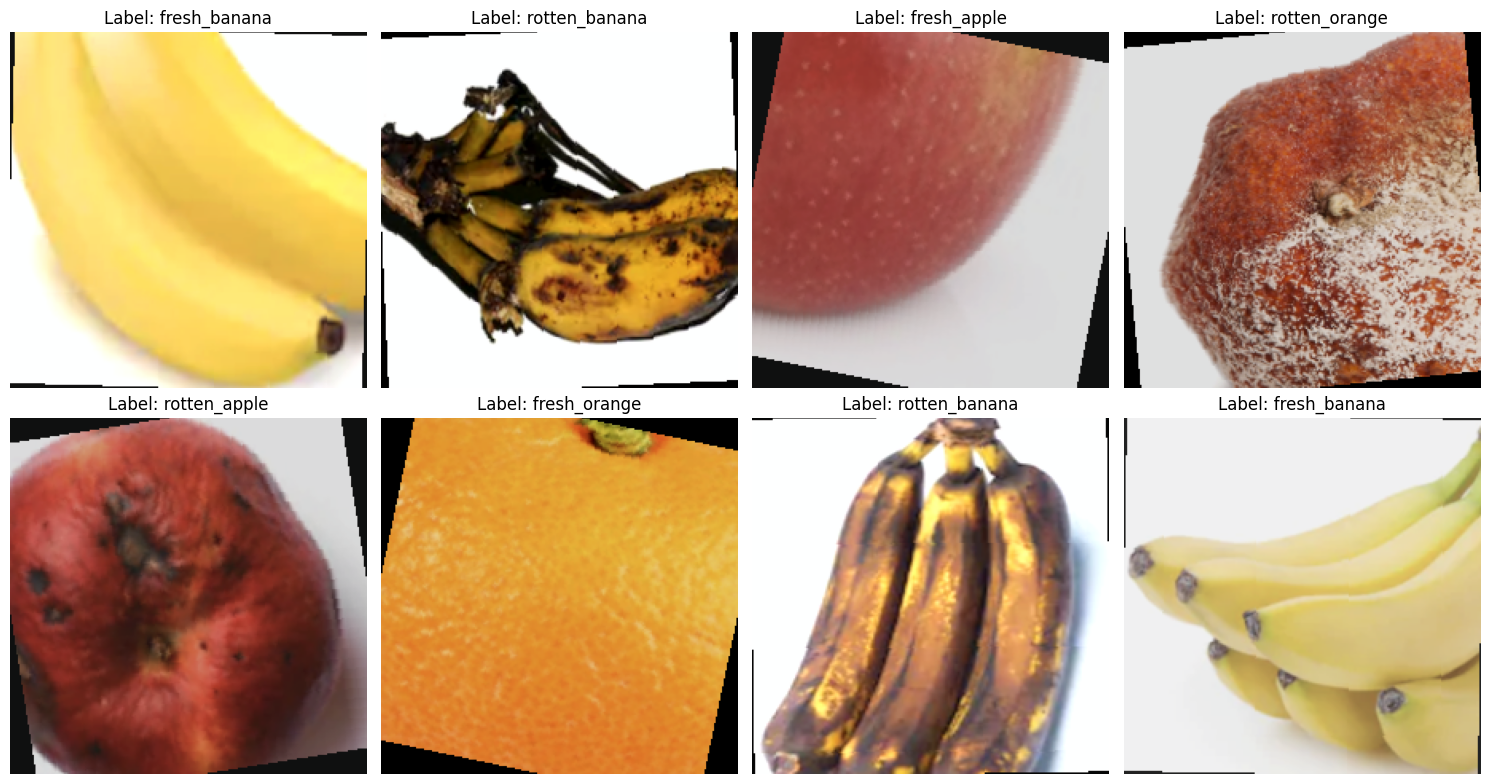

In [12]:
# # Visualize a batch from the train_loader
visualize_batch(train_loader, classes)  # Training samples with augmentation

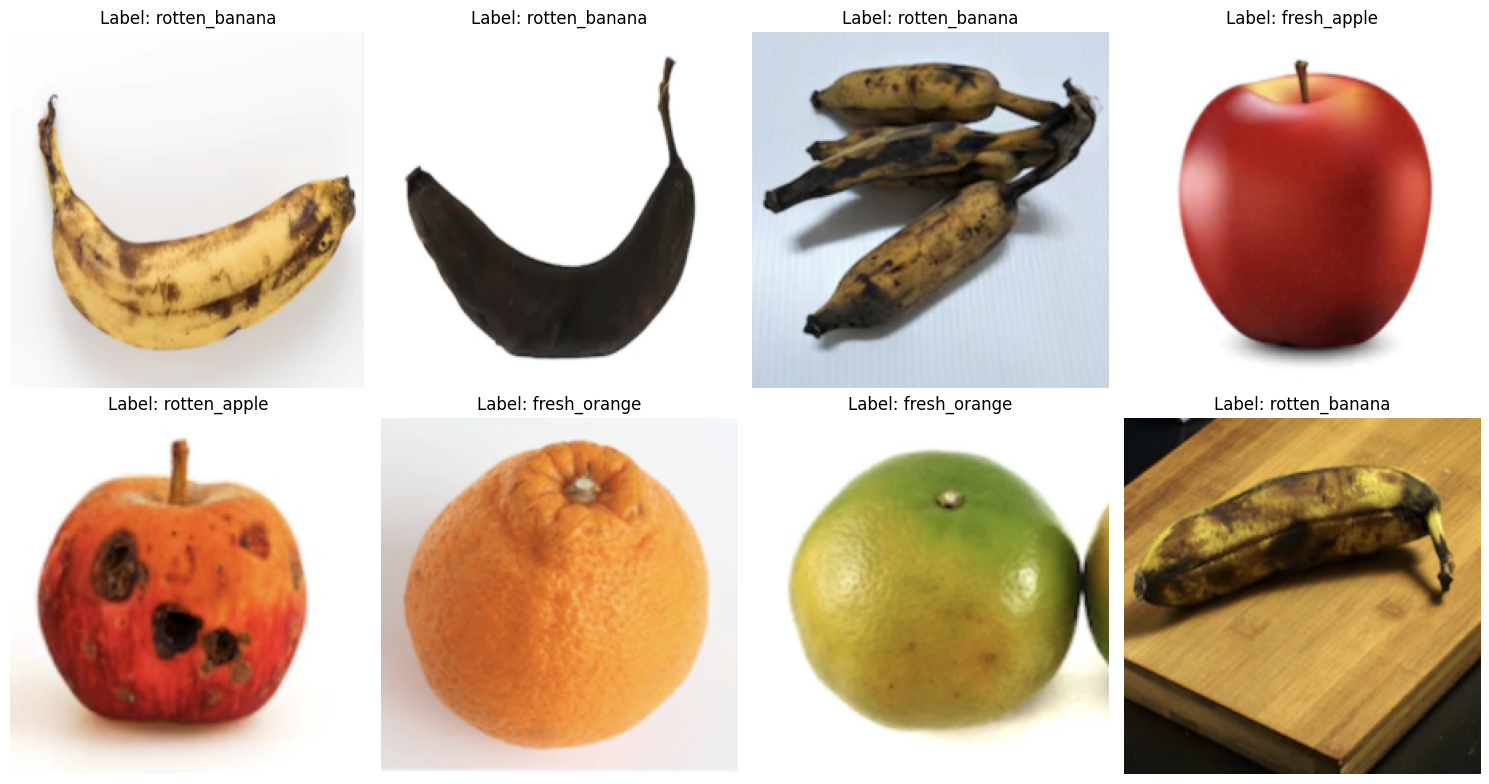

In [13]:
visualize_batch(val_loader, classes)  # Validation samples, no augmentation

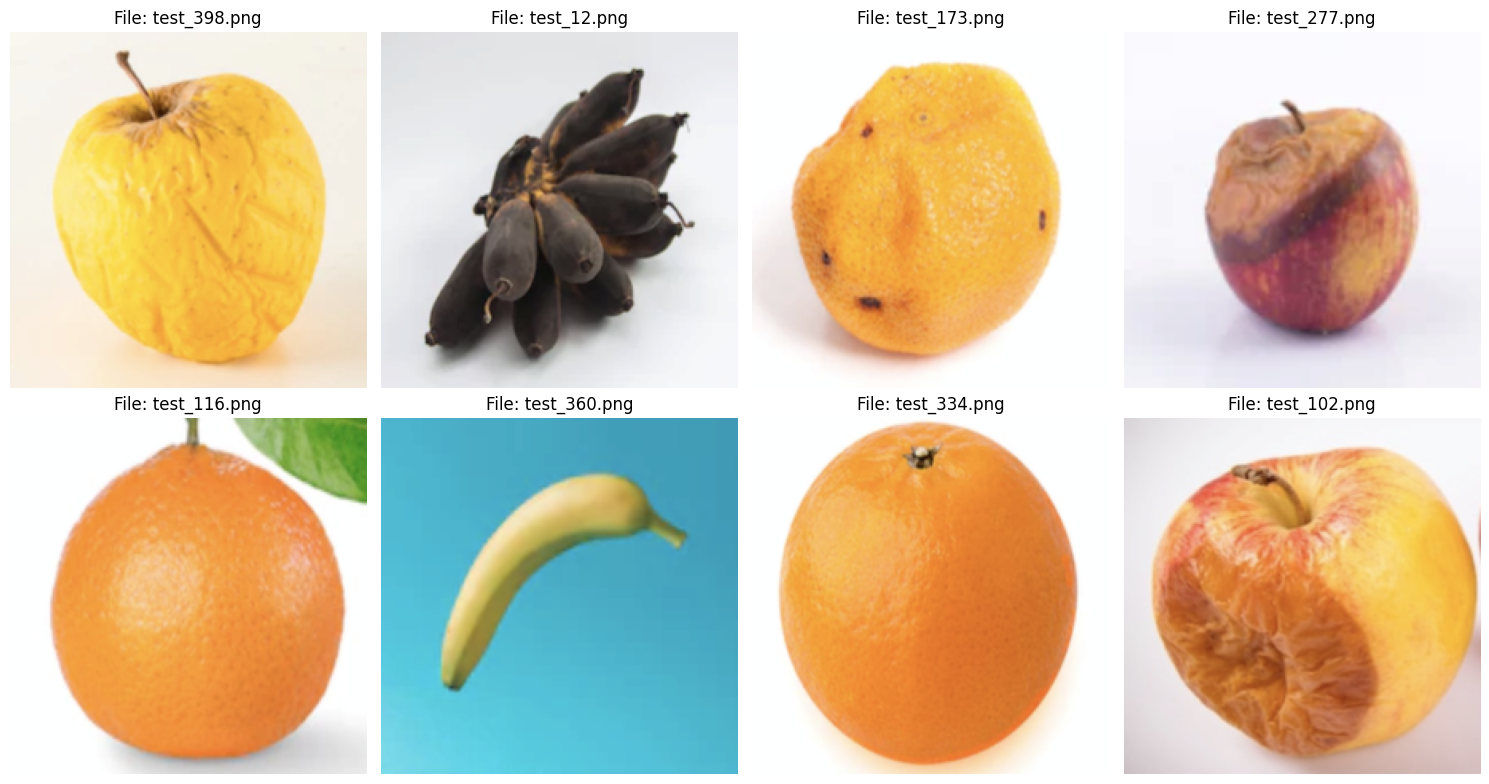

In [14]:
visualize_batch(test_loader, classes)  # Test samples, no augmentation

# Neural network


In [15]:
# Define the cnn
import torch
import torch.nn as nn
import torch.nn.functional as F

class FruitClassification(nn.Module):
    def __init__(self, num_classes=6):
        super(FruitClassification, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        
        self.fc1 = nn.Linear(256 * 3 * 3, 120)
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))    
        x = F.max_pool2d(x, 2)                 

        x = F.relu(self.bn2(self.conv2(x)))    
        x = F.max_pool2d(x, 2)                 

        x = F.relu(self.bn3(self.conv3(x)))    
        x = F.max_pool2d(x, 2)  
        
        x = F.relu(self.bn4(self.conv4(x)))    
        x = F.max_pool2d(x, 2)    

        x = F.relu(self.bn5(self.conv5(x)))    
        x = F.max_pool2d(x, 2)     
        
        x = F.adaptive_avg_pool2d(x, (3, 3))   
        x = x.view(x.size(0), -1)              

        x = F.relu(self.dropout1(self.fc1(x))) 
        x = F.relu(self.dropout2(self.fc2(x))) 
        x = self.fc3(x)                        

        return x

      


model = FruitClassification(num_classes=6).to(device)

# Loss Function

In [16]:

images = torch.randn(8, 3, 224, 224)  # (batch_size, channels, height, width)

# prediction
logits = model(images.to(device))

# softmax
probabilities = F.softmax(logits, dim=1)
print("Probabilities:", probabilities)


labels = torch.randint(0, 6, (8,)).to(device)  # Batch de 8 labels

# Loss function
ce_loss = nn.CrossEntropyLoss(label_smoothing=0.1)
ce_loss = ce_loss.to(device)

loss = ce_loss(logits, labels)
print("Loss:", loss.item())

Probabilities: tensor([[0.2076, 0.1490, 0.1512, 0.1457, 0.1691, 0.1774],
        [0.1575, 0.1850, 0.1477, 0.1845, 0.1602, 0.1651],
        [0.1866, 0.1825, 0.1427, 0.1398, 0.1709, 0.1775],
        [0.1988, 0.2088, 0.1489, 0.1519, 0.1282, 0.1633],
        [0.1374, 0.1918, 0.1422, 0.1442, 0.2171, 0.1673],
        [0.2070, 0.2138, 0.1307, 0.1924, 0.1297, 0.1264],
        [0.1410, 0.1764, 0.1314, 0.1855, 0.2015, 0.1643],
        [0.2199, 0.1829, 0.1018, 0.1306, 0.1799, 0.1850]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Loss: 1.7925609350204468


# Adam Optimizer and Learning rate 

In [17]:
# define optimiser 
from torch.optim import Adam
optimizer = Adam(
            model.parameters(),
            lr=0.0001)

# Compute gradients and update weights
loss.backward()
optimizer.step()


# Computer accurary

In [18]:
def get_batch_accuracy(output, y):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / output.shape[0]

# Lists to track metrics

In [19]:
train_losses = []
train_accuracies = [] 
valid_losses = []
valid_accuracies = []

# Training

In [20]:
EPOCHS = 150

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = ce_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += get_batch_accuracy(outputs, labels)
    
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_acc = epoch_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = ce_loss(outputs, labels)
            
            val_loss += loss.item()
            val_acc += get_batch_accuracy(outputs, labels)
            
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    valid_losses.append(avg_val_loss)
    valid_accuracies.append(avg_val_acc)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            
    global_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f},",
          f"Global Accuracy: {global_accuracy:.4f}")


Epoch 1/150: Train Loss: 1.7420, Train Acc: 0.2523, Val Loss: 1.7029, Val Acc: 0.3491, Global Accuracy: 0.3491
Epoch 2/150: Train Loss: 1.5904, Train Acc: 0.4187, Val Loss: 1.4547, Val Acc: 0.5661, Global Accuracy: 0.5755
Epoch 3/150: Train Loss: 1.4408, Train Acc: 0.5190, Val Loss: 1.2589, Val Acc: 0.6902, Global Accuracy: 0.6981
Epoch 4/150: Train Loss: 1.3092, Train Acc: 0.5663, Val Loss: 1.0899, Val Acc: 0.7679, Global Accuracy: 0.7689
Epoch 5/150: Train Loss: 1.1926, Train Acc: 0.6576, Val Loss: 1.0140, Val Acc: 0.7330, Global Accuracy: 0.7406
Epoch 6/150: Train Loss: 1.1805, Train Acc: 0.6549, Val Loss: 0.9104, Val Acc: 0.8241, Global Accuracy: 0.8255
Epoch 7/150: Train Loss: 1.1094, Train Acc: 0.7032, Val Loss: 0.8620, Val Acc: 0.8232, Global Accuracy: 0.8302
Epoch 8/150: Train Loss: 1.0975, Train Acc: 0.7067, Val Loss: 0.8324, Val Acc: 0.8304, Global Accuracy: 0.8349
Epoch 9/150: Train Loss: 1.0875, Train Acc: 0.6839, Val Loss: 0.8197, Val Acc: 0.8598, Global Accuracy: 0.8632
E

# Test dataloader images

In [21]:
# result lists
all_preds = []
all_labels = []

# model in eval mode 
model.eval()

# test all dataloader images
with torch.no_grad():  
    for images, img_names in test_loader:
        images = images.to(device)  
        outputs = model(images)  

        # apply softmax for probabilities
        probabilities = torch.softmax(outputs, dim=1)

        # prediction for each class
        _, predicted_classes = torch.max(probabilities, 1)

        # save predictions and name images
        all_preds.extend(predicted_classes.cpu().numpy()) 
        all_labels.extend(img_names) 

# print results
for img_name, pred in zip(all_labels, all_preds):
    print(f"Image: {img_name} => Predicted Class: {classes[pred]}")



Image: test_398.png => Predicted Class: rotten_apple
Image: test_12.png => Predicted Class: rotten_banana
Image: test_173.png => Predicted Class: fresh_orange
Image: test_277.png => Predicted Class: rotten_apple
Image: test_116.png => Predicted Class: fresh_orange
Image: test_360.png => Predicted Class: fresh_banana
Image: test_334.png => Predicted Class: fresh_orange
Image: test_102.png => Predicted Class: rotten_apple
Image: test_304.png => Predicted Class: fresh_banana
Image: test_354.png => Predicted Class: fresh_orange
Image: test_127.png => Predicted Class: fresh_orange
Image: test_46.png => Predicted Class: fresh_banana
Image: test_429.png => Predicted Class: rotten_orange
Image: test_126.png => Predicted Class: rotten_banana
Image: test_100.png => Predicted Class: rotten_orange
Image: test_62.png => Predicted Class: rotten_orange
Image: test_108.png => Predicted Class: fresh_banana
Image: test_267.png => Predicted Class: rotten_apple
Image: test_130.png => Predicted Class: rott

# Print predictions

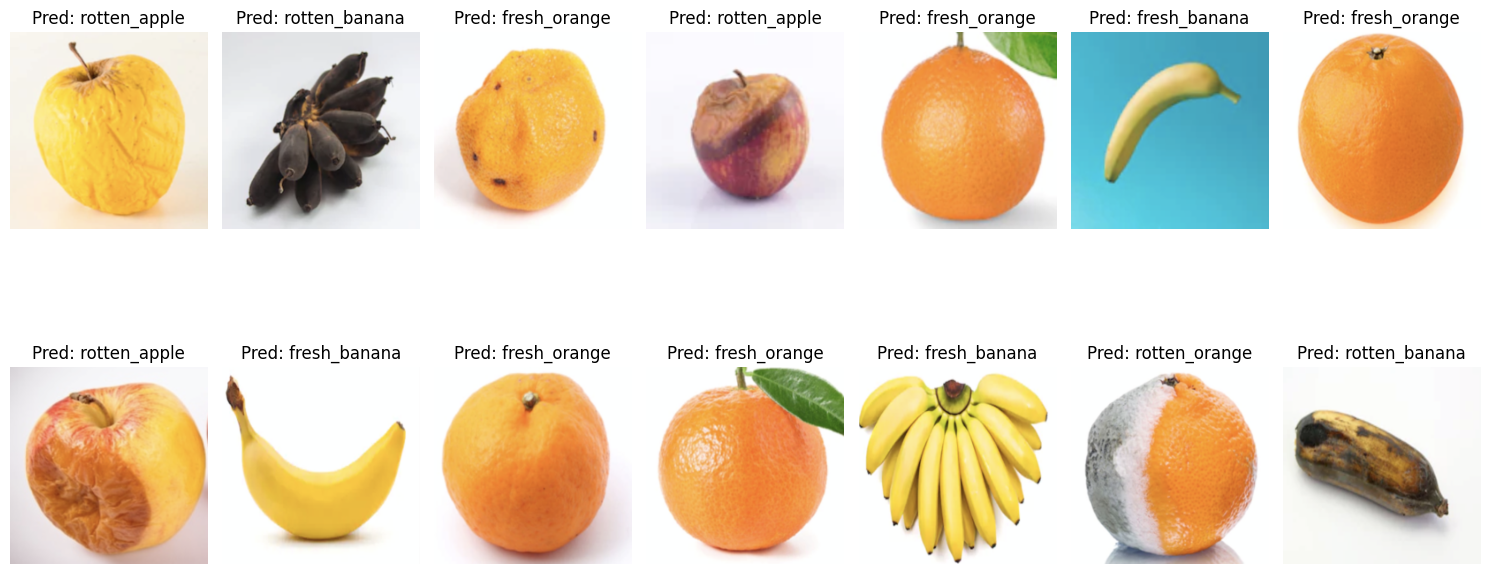

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# print images with names
def visualize_predictions(test_loader, model, class_names, n=15):
    model.eval()  
    images, img_names = next(iter(test_loader)) 
    images = images.to(device)  

    # Predictions
    with torch.no_grad(): 
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted_classes = torch.max(probabilities, 1)

    # convert images to numpy format
    images = images.cpu().numpy() 
    images = np.transpose(images, (0, 2, 3, 1)) 

    # Denormalize images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean 
    images = np.clip(images, 0, 1)  

    # print images with predictions
    fig, axes = plt.subplots(2, n // 2, figsize=(15, 8))
    axes = axes.flatten()

    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        pred_class = class_names[predicted_classes[i].item()]
        ax.set_title(f"Pred: {pred_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# vizualize predictions
visualize_predictions(test_loader, model, classes)


In [23]:
# create a submission csv file
submission_data = []
for img_name, pred in zip(all_labels, all_preds):
    submission_data.append({
        "Id": img_name,
        "Label": classes[pred]
    })


submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("submission.csv", index=False)

import os
print(os.listdir('/kaggle/working'))

['__notebook__.ipynb', 'submission.csv']
